**Clone darknet repository**

In [1]:
!git clone https://github.com/AlexeyAB/darknet/

Cloning into 'darknet'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 10411 (delta 0), reused 2 (delta 0), pack-reused 10407
Receiving objects: 100% (10411/10411), 10.16 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (7026/7026), done.


**Get yolo3 weights file**

In [2]:
%cd darknet
!wget https://pjreddie.com/media/files/yolov3.weights

/content/darknet
--2019-06-13 03:53:53--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  6.93MB/s    in 11s     

2019-06-13 03:54:04 (21.6 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



**Set OPENCV=1 and GPU=1 in Makefile**

In [0]:
!pwd
!sed -i 's/OPENCV=0/OPENCV=1/g' Makefile
!sed -i 's/GPU=0/GPU=1/g' Makefile

**Determine if GPU is using**

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

**Build darknet**

In [0]:
!make

**Verify darknet is installed correctly**

In [0]:
!./darknet detect cfg/yolov3.cfg yolov3.weights data/giraffe.jpg

**Predict using opencv**

In [0]:
import numpy as np
import cv2
import time

In [5]:
CONFIDENCE = 0.5
THRESHOLD = 0.5

LABELS = open('data/coco.names').read().strip().split("\n")
print(LABELS)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [0]:
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [0]:
net = cv2.dnn.readNetFromDarknet('cfg/yolov3.cfg', 'yolov3.weights')

In [0]:
# load our input image and grab its spatial dimensions
image = cv2.imread('data/dog.jpg')
(H, W) = image.shape[:2]

In [0]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [10]:
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
 
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 1.962991 seconds


In [0]:
# initialize our lists of detected bounding boxes, confidences, and class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [0]:
# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of
		# the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
 
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > CONFIDENCE:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
 
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
 
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [0]:
# apply non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE, THRESHOLD)

In [0]:
# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
 
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

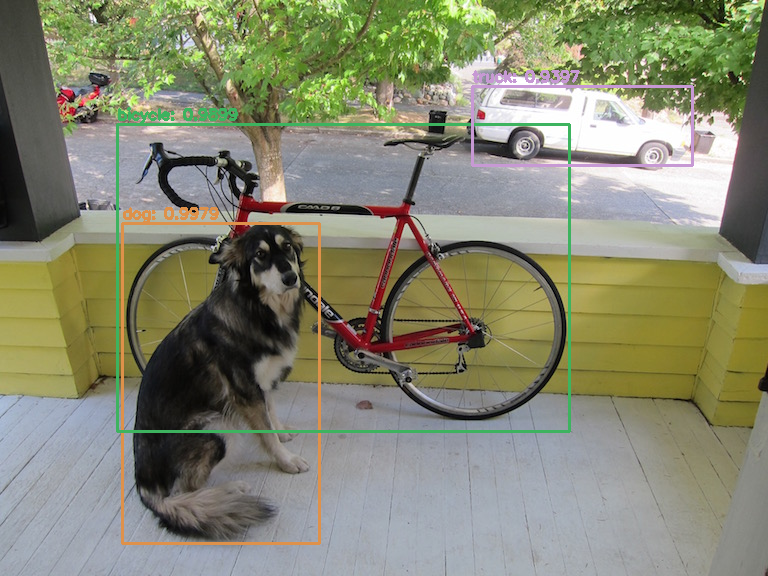

In [15]:
# show the output image
from google.colab.patches import cv2_imshow
cv2_imshow(image)